# CMSC320: Checkpoint 2
Tyshon Brown, David Li, Zile Liu, and Samuel Opoku-Agyemang


## Data Pre-Processing

### Imports

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from census import Census

sns.set_theme()

c = Census("23c580dcbb047d99e93502f60681fc6430f2fc9a", year=2020)  # Sam's API key

/Users/davidli/cmsc320_project/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Population

In [2]:
population_data = c.acs5.state(("NAME", "B01003_001E"), Census.ALL)
population = pd.DataFrame(population_data)
population.rename(columns={"NAME": "Name", "B01003_001E": "Population"}, inplace=True)
population["Population"] = population["Population"].astype(int)

population = population.drop("state", axis=1)
population.head()

,Name,Population
0,Pennsylvania,12794885
1,California,39346023
2,West Virginia,1807426
3,Utah,3151239
4,New York,19514849


### Population Density

In [3]:
# https://www.census.gov/data/tables/time-series/dec/density-data-text.html
# renamed from "apportionment.csv"
pop_density = pd.read_csv("population_density.csv")
pop_density = pop_density[
    ["Name", "Geography Type", "Year", "Resident Population Density"]
]
pop_density = pop_density[
    (pop_density["Year"] == 2020) & (pop_density["Geography Type"] == "State")
]
pop_density = pop_density[["Name", "Resident Population Density"]].reset_index(
    drop=True
)

# 52 datapoints because DC and Puerto Rico count as states
pop_density.head()

,Name,Resident Population Density
0,Alabama,99.2
1,Alaska,1.3
2,Arizona,62.9
3,Arkansas,57.9
4,California,253.7


### Median Age

In [4]:
median_age_dictionary = c.acs5.state(("NAME", "B01002_001E"), Census.ALL)
median_age = pd.DataFrame.from_dict(median_age_dictionary).rename(
    columns={"NAME": "Name", "B01002_001E": "Median Age"}
)
median_age = (
    median_age[["Name", "Median Age"]].sort_values(by=["Name"]).reset_index(drop=True)
)
median_age.head()

,Name,Median Age
0,Alabama,39.2
1,Alaska,34.6
2,Arizona,37.9
3,Arkansas,38.3
4,California,36.7


### Median Income

In [5]:
median_income_dictionary = c.acs5.state(("NAME", "B19013_001E"), Census.ALL)
median_income = pd.DataFrame.from_dict(median_income_dictionary).rename(
    columns={"NAME": "Name", "B19013_001E": "Median Household Income"}
)
median_income = (
    median_income[["Name", "Median Household Income"]]
    .sort_values(by=["Name"])
    .reset_index(drop=True)
)
median_income.head()

,Name,Median Household Income
0,Alabama,52035.0
1,Alaska,77790.0
2,Arizona,61529.0
3,Arkansas,49475.0
4,California,78672.0


### Popular Vote

In [6]:
# https://www.fec.gov/introduction-campaign-finance/election-results-and-voting-information/federal-elections-2020/
popular_vote = pd.read_csv("federalelections2020.csv")
popular_vote.head()

,Name,Biden Votes,Trump Votes,Total Votes
0,Alabama,849624,1441170,2323282
1,Alaska,153778,189951,359530
2,Arizona,1672143,1661686,3387326
3,Arkansas,423932,760647,1219069
4,California,11110639,6006518,17501380


## Funding

In [7]:
## Source: https://www.fec.gov/resources/campaign-finance-statistics/2020/tables/ie/IE2_2020_24m.pdf
independent_expenditure = pd.read_csv("candidates_funding.csv")
independent_expenditure = independent_expenditure.sort_values(
    by=["Total IEs For"], ascending=False
)
independent_expenditure.index = range(0, len(independent_expenditure))
independent_expenditure.head()

,Candidate,Total IEs For,Total IEs Against
0,"Biden, Joseph R Jr",383204094,299388312
1,"Trump, Donald J.",53500635,308135887
2,"Warren, Elizabeth",14996979,18965
3,"Buttigieg, Pete",3668912,30862
4,"Klobuchar, Amy J.",2711204,101


In [8]:
state_contributions = pd.read_csv("state_spending.csv")
state_contributions = state_contributions.rename(
    columns={"State (or District)": "Name"}
).drop(columns=["Rank"])
state_contributions["Total Contributions"] = (
    state_contributions["Total Contributions"].str.replace("$", "").astype(int)
)
state_contributions["Percent to Democrats"] = (
    state_contributions["Percent to Democrats"].str.replace("%", "").astype(float) / 100
)
state_contributions["Percent to Republicans"] = (
    state_contributions["Percent to Republicans"].str.replace("%", "").astype(float)
    / 100
)
state_contributions["Contributions to Democrats"] = (
    state_contributions["Total Contributions"]
    * state_contributions["Percent to Democrats"]
)
state_contributions["Contributions to Republicans"] = (
    state_contributions["Total Contributions"]
    * state_contributions["Percent to Republicans"]
)
state_contributions.head()

,Name,Total Contributions,Percent to Democrats,Percent to Republicans,Contributions to Democrats,Contributions to Republicans
0,California,1666572970,0.6931,0.2842,1.155102e+09,4.736400e+08
1,New York,978988661,0.7462,0.2318,7.305213e+08,2.269296e+08
2,District of Columbia,810155426,0.6701,0.3148,5.428852e+08,2.550369e+08
3,Texas,687622660,0.3488,0.6315,2.398428e+08,4.342337e+08
4,Florida,646468276,0.3692,0.6108,2.386761e+08,3.948628e+08


## Hypothesis Testing

We focus on the 2020 presidential election because the FEC data for Trump's 2024 campaign is currently incomplete.

### Median Age and Party-Based Spending
* How does median age correlate with funds raised?
* Did Republican candidates receive a disproportion amount of funding from states with a higher median age?

We perform a one-way ANOVA and a Tukey's honest significant difference test. Our null hypothesis is that the proportion of contributions to Democrats/Republicans from a state is independent of its median age.

In [9]:
from scipy.stats import f_oneway

joint_df = pd.merge(left=median_age, right=state_contributions, how="inner")
joint_df = pd.merge(left=joint_df, right=population, how="inner")
joint_df.insert(
    2,
    "Age Group",
    pd.qcut(joint_df["Median Age"], q=3, labels=["Lower", "Medium", "Higher"]),
)


lower = joint_df[joint_df["Age Group"] == "Lower"]["Percent to Republicans"]
medium = joint_df[joint_df["Age Group"] == "Medium"]["Percent to Republicans"]
higher = joint_df[joint_df["Age Group"] == "Higher"]["Percent to Republicans"]

statistic, p_value = f_oneway(lower, medium, higher)
print(f"ANOVA statistic:{statistic:.4f}, ANOVA p_value: {p_value:.4f}")
# singificant, so we proceed with a post-hoc Tukey's Honest Significant Difference

import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(joint_df["Percent to Republicans"], joint_df["Age Group"])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

ANOVA statistic:5.3387, ANOVA p_value: 0.0081


group1,group2,meandiff,p-adj,lower,upper,reject
Higher,Lower,0.1779,0.0063,0.0445,0.3112,True
Higher,Medium,0.1137,0.1085,-0.0196,0.2471,False
Lower,Medium,-0.0641,0.4806,-0.1975,0.0692,False


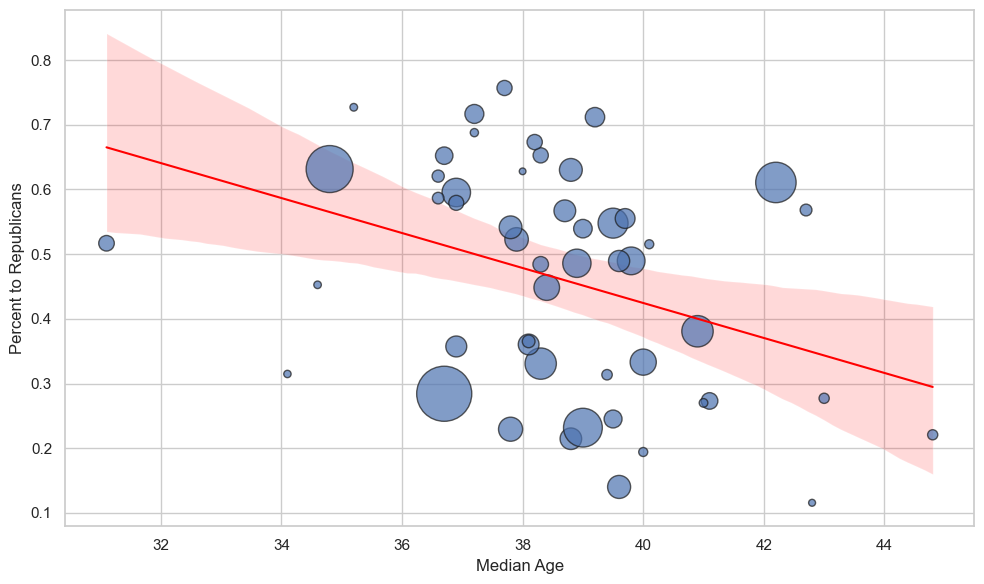

In [10]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Regression Line
sns.regplot(
    data=joint_df,
    x="Median Age",
    y="Percent to Republicans",
    scatter=False,
    color="red",
    line_kws={"linewidth": 1.5},
)

# Scatter Plot
plt.scatter(
    x=joint_df["Median Age"],
    y=joint_df["Percent to Republicans"],
    s=joint_df["Population"] / 25000,
    alpha=0.7,
    edgecolor="k",
)
plt.tight_layout()
plt.show()

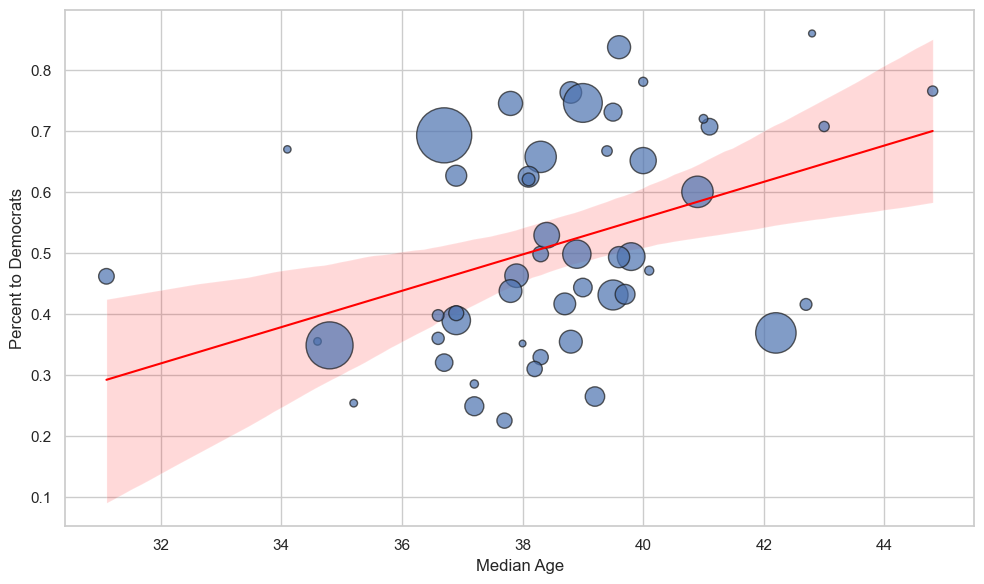

In [11]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Regression Line
sns.regplot(
    data=joint_df,
    x="Median Age",
    y="Percent to Democrats",
    scatter=False,
    color="red",
    line_kws={"linewidth": 1.5},
)

# Scatter Plot
plt.scatter(
    x=joint_df["Median Age"],
    y=joint_df["Percent to Democrats"],
    s=joint_df["Population"] / 25000,
    alpha=0.7,
    edgecolor="k",
)
plt.tight_layout()
plt.show()

**Conclusion**

The ANOVA p-value of 0.0081 disproves the null hypothesis. As median age increases, the Democrats receive more funding and the Republicans receive less funding.

### Population Density and Voter Turnout
- How does population density correlate with voter turnout?
- Do denser areas have more engaged voters?

We perform a simple linear regression. We use Pearson and Spearman correlation analyses to test the null hypothesis that a state's voter turnout is independent of its population density.

**Turnout Rate:**

In [12]:
merged_pop_df = popular_vote.merge(population, on="Name")
merged_pop_df["Turnout"] = merged_pop_df["Total Votes"] / merged_pop_df["Population"]

# popular_vote['Turnout'] = popular_vote['Total Votes'] / population['Population']
merged_pop_df.head(5)

,Name,Biden Votes,Trump Votes,Total Votes,Population,Turnout
0,Alabama,849624,1441170,2323282,4893186,0.474799
1,Alaska,153778,189951,359530,736990,0.487836
2,Arizona,1672143,1661686,3387326,7174064,0.472163
3,Arkansas,423932,760647,1219069,3011873,0.404754
4,California,11110639,6006518,17501380,39346023,0.444807


**Combining** DF's for Visualization:

In [13]:
# merging Popular Vote and Population Density and Population
density_turnout = merged_pop_df.merge(pop_density, on="Name")

# Calculating turnout and adding it to the df
density_turnout["Turnout"] = (
    density_turnout["Total Votes"] / density_turnout["Population"] * 100
)
density_turnout["Resident Population Density"] = pd.to_numeric(
    density_turnout["Resident Population Density"], errors="coerce"
)

# Dropping Na's
density_turnout = density_turnout.dropna(
    subset=["Resident Population Density", "Turnout"]
)

density_turnout.head()

,Name,Biden Votes,Trump Votes,Total Votes,Population,Turnout,Resident Population Density
0,Alabama,849624,1441170,2323282,4893186,47.479945,99.2
1,Alaska,153778,189951,359530,736990,48.783566,1.3
2,Arizona,1672143,1661686,3387326,7174064,47.216278,62.9
3,Arkansas,423932,760647,1219069,3011873,40.475445,57.9
4,California,11110639,6006518,17501380,39346023,44.480684,253.7


The Plot:
- x-axis: Population Density
- y-axis: Voter Turnout
- blue dots/points: scaled to the population size
- red regression line

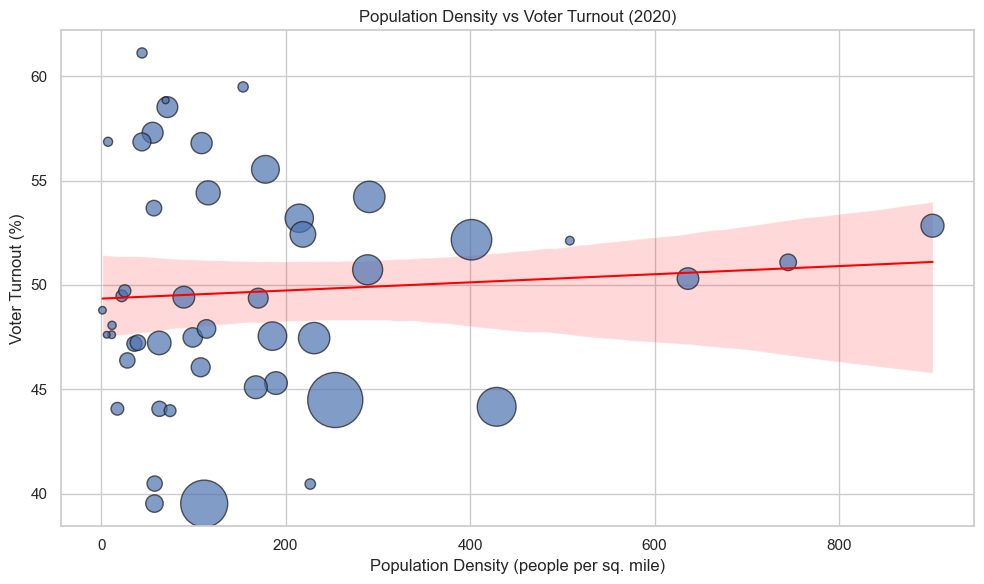

Pearson correlation: 0.070, p-value: 0.636
Spearman correlation: 0.051, p-value: 0.733


In [14]:
from scipy.stats import pearsonr, spearmanr

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Regression Line
sns.regplot(
    data=density_turnout,
    x="Resident Population Density",
    y="Turnout",
    scatter=False,
    color="red",
    line_kws={"linewidth": 1.5},
)


# Scatter Plot
plt.scatter(
    x=density_turnout["Resident Population Density"],
    y=density_turnout["Turnout"],
    s=density_turnout["Population"] / 25000,
    alpha=0.7,
    edgecolor="k",
)

plt.xlabel("Population Density (people per sq. mile)")
plt.ylabel("Voter Turnout (%)")
plt.title("Population Density vs Voter Turnout (2020)")
plt.tight_layout()
plt.show()

# Pearson Correlation
p_corr, p_p = pearsonr(
    density_turnout["Resident Population Density"], density_turnout["Turnout"]
)
print(f"Pearson correlation: {p_corr:.3f}, p-value: {p_p:.3g}")

# Spearman Correlation
s_corr, s_p = spearmanr(
    density_turnout["Resident Population Density"], density_turnout["Turnout"]
)
print(f"Spearman correlation: {s_corr:.3f}, p-value: {s_p:.3g}")

**Conclusion**

In most of the cases where the voter turnout is high, the population density is on the lower side. But, it is also the same for the low voter turnout. A Pearson Correlation coefficient of 0.070 shows that there is a **very weak** positive linear correlation. A Spearman Correlation coefficient of 0.051 shows that there is also a **very weak** positive correlation. Both p-values are large (> 0.05) so they are insignificant, and we fail to disprove the null hypothesis. Thus, there is **no significant correlation** between population density and voter turnout across the states. Both the Pearson and Spearman correlation values are close to zero. The visualization also shows no clear pattern between population density and voter turnout.